# Introduction to simpleDAS

simpleDAS is python library that allow for simple reading, processing and saving of the ASN OptoDAS file format. 

The latest version 8 is significantly rewritten and the primary data container used is pandas dataframe. The dataframe is a representation of a 2D numpy that allows for user specified labels on each column and row.  

SimpleDAS outputs a dataframe with channel numbers as column labels and timestamps as the row labels. In addition the returned dataframe includes additional metainformation obtained from the read files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import mlab
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]
pd.options.display.max_rows = 8
pd.options.display.max_columns = 8
np.set_printoptions(threshold=20)
import scipy.signal as sps
import datetime
from IPython.display import SVG,display,Image
import sys,os
sys.path.append(os.path.abspath('..'))
import simpleDASreader8 as simpleDASreader


## Reading DAS files

The OptoDAS files are read using function load_DAS_files in simpleDASreader8.py. 

In [159]:
help(simpleDASreader.load_DAS_files)

Help on function load_DAS_files in module simpleDASreader8:

load_DAS_files(filepaths, chIndex=None, samples=None, sensitivitySelect=0, integrate=True, unwr=True, spikeThr=None, userSensitivity=None)
    Loads OptoDAS recorded datafiles to pandas dataframe.
    
    
    Parameters
    ----------
    filepaths: string or list of strings
        Full path + filename of files to load.
        
    chIndex: 1d array, list, slice or None
        Channel indices to load.
        None => load all available channels (default).
        
    samples: slice, int, or None
        Time indices to read. When reading multiple files,
        the index counter continous into subsequent files.
        None  => load all available time samples (default). 
        int   => Load this number of samples, starting from first sample.
        slice => Range of indices, i.e. samples=slice(start,stop) 
        Note: Decimation should be performed after cumsum or antialiasing.
              Decimation with the sli

The obligatory parameters to **load_DAS_files** are:  
**filepaths**: A list with full path to files to load.   
**chIndex**  : The channel indexes in the file to load. NB this is not the same as channel numbers as it depends on region of interest (ROI) parameters of the recording.   
**samples**  : A list or range of the time sample indexes to be read.  

In addition there are some optional parameters:  
**sensitivitySelect**: The sensitivity value to convert data in the file (usually rad/m) to sensitivityUnit. The file format allows for multiple sensitivity factors, however currently only the sensitivity to strain is implemented. Default value is 0, which gives scaling to unit strain. Values -1 and -2 gives output in rad/m and rad, respectively.  
**integrate**: The data recorded by the instrument is phase rate. Default value True, which provide data in strain. False gives strain per second.  
**unwr,spikeThr**: Parameters to handle large stain rates, see doc.  
**userSensitivity**: User defined sensitivity. Dictionary that includes keys 'sensitivity' and 'sensitivityUnit'. Use sensitivitySelect=-3 to use this sensitivity.

The function returns a dataframe of type DASDataFrame, which is a pandas dataframe with absolute timestamp as row labels and channel number as column labels. In addition there is a meta object that includes meta info regarding the dataset.

**signal.meta** dict fields:  
> **fileVersion**: format version number of the input file  
> **time**: timestamp of first sample as a datetime.datetime object  
> **dx**: channel separation in m  
> **dt**: sample interval in s  
> **gaugeLength**: sensor gaugelength in m  
> **unit**: unit of data. Note that this is the unit after applying sensitivity, not the unit of the data in the file.  
> **sensitivities,sensitivityUnits**: sensitivities that can applied to data after reading. Note that this values are only available if data is returned as rad/m or rad (sensitivitySelect=-1 or -2).  
> **filepaths**: The paths to the files read.  

Example usage:

In [3]:
filepaths = ['/raid1/FSI_Testdata/FileVersion8/v8test_dascontrol/20220422/dphi/075908.hdf5',
 '/raid1/FSI_Testdata/FileVersion8/v8test_dascontrol/20220422/dphi/075918.hdf5']

chIndex = slice(7500,10500,4) # slice is the array slicing operator
samples = slice(1000,10000)
signal = simpleDASreader.load_DAS_files(filepaths, chIndex, samples)

Loaded files ['075908.hdf5', '075918.hdf5']  in 9.0 s


In [4]:
print(type(signal))
display(signal)
display(signal.meta)

<class 'simpleDASreader8.DASDataFrame'>


,7500,7504,7508,7512,...,10484,10488,10492,10496
2022-04-22 07:59:08.125000,-5.615083e-11,-3.008081e-11,-2.005387e-12,2.005387e-12,...,1.694552e-10,-2.967973e-09,-3.137428e-09,-4.802902e-10
2022-04-22 07:59:08.125125,-3.810235e-11,-1.804849e-11,-7.018855e-12,-1.604310e-11,...,-2.157797e-09,-3.854354e-09,-6.140495e-09,-2.502723e-09
2022-04-22 07:59:08.125250,-1.082909e-10,-7.821010e-11,-4.712660e-11,-8.021548e-12,...,5.499774e-09,3.765114e-09,3.967659e-09,6.492441e-09
2022-04-22 07:59:08.125375,-1.293475e-10,-9.124511e-11,-4.913198e-11,-1.504040e-11,...,9.466429e-09,8.187996e-09,5.176907e-09,6.073315e-09
...,...,...,...,...,...,...,...,...,...
2022-04-22 07:59:09.249500,1.092929e-10,1.774756e-10,2.135738e-10,2.506735e-10,...,-4.309556e-07,-6.558905e-07,-8.126356e-07,-8.651086e-07
2022-04-22 07:59:09.249625,8.021481e-11,1.654433e-10,2.115684e-10,2.767435e-10,...,-4.336418e-07,-6.576302e-07,-8.122225e-07,-8.646272e-07
2022-04-22 07:59:09.249750,-1.022754e-10,2.707158e-11,1.403772e-10,2.647112e-10,...,-4.316064e-07,-6.565663e-07,-8.092605e-07,-8.618869e-07
2022-04-22 07:59:09.249875,9.324983e-11,1.925160e-10,2.195899e-10,2.466627e-10,...,-4.336038e-07,-6.584954e-07,-8.107104e-07,-8.626850e-07


{'fileVersion': array(8, dtype=int32),
 'time': datetime.datetime(2022, 4, 22, 7, 59, 8, 125000),
 'dataType': array(3, dtype=int32),
 'dt': array(0.000125),
 'dx': array(1.02130019),
 'gaugeLength': array(40.85200763),
 'unit': 'strain',
 'sensitivities': array([[1.]], dtype=float32),
 'sensitivityUnits': [''],
 'filepaths': ['/raid1/FSI_Testdata/FileVersion8/v8test_dascontrol/20220422/dphi/075908.hdf5',
  '/raid1/FSI_Testdata/FileVersion8/v8test_dascontrol/20220422/dphi/075918.hdf5']}

## Finding DAS data

Often we want to extract data from a spesific timestamp rather than a spesific DAS files. The DAS is organized in 10 s files with a path structure as follows:
> /\<data root path\>/\<experiment name\>/\<YYYYmmdd\>/\<datatype name\>/\<HHMMSS\>.hdf5  

where \<YYYYmmdd\> is the date and \<HHMMSS\> is the time of the first sample in the file. The recording can be started on an arbitrary second, which means that last digit in the file name may be unknown. 

In order to extract data from a specific time stamp, the function **find_DAS_files** can be used.

The obligatory parameters to **find_DAS_files** are:  
**experiment_path**:File path containing DAS files. Should point to /\<data root path\>/\<experiment name\>/. Pointing directly to the directory containing the files is also supported.  
**start**:Start time of data to extract on format 'YYYYmmdd HHMMSS'. May also be datetime.datetime object.  
**duration**: Duration in seconds to be loaded. May also be datetime.timedelta object

In addition there are some optional parameters:  
**channels**: List of DAS channels to read. Also accept as slice(start_channel, stop_channel, step). Load all if None.  
**datatype**: Datatype name/subfolder to read. Usually 'dphi' (default) or 'proc'.      
**load_file_from_start**:It True, load from start of the file containing the start timestamp, else calculated to sampleno corresponing to start timestamp

Returns **filepaths, chIndex, samples** that can be directly used as input to **load_DAS_files**.

Example usage:

In [84]:
#%% Find input files from experiment input folder and time interval

#input_folder = '/mnt/superb_raid1//FSI_Testdata/FileVersion8/v8test_dascontrol'
input_folder = '/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep'
start = datetime.datetime(2021, 5, 31, 5, 44, 0)
duration = datetime.timedelta(seconds=20)

# Request a subset of channels. The function below will inspect the file and 
# determine which channels exist in the file, returned as the chIndex variable
channels = np.arange(4000, 5000, 1)

filepaths, chIndex, samples = simpleDASreader.find_DAS_files(input_folder, start, duration,
                                                              channels=channels,load_file_from_start=False)
signal = simpleDASreader.load_DAS_files(filepaths, chIndex, samples)

-- Channel info file: 054357.hdf5 --
	1800 channels in file:	[   0    5   10 ... 8985 8990 8995]
	1000 channels requested:	[4000 4001 4002 ... 4997 4998 4999]
	200 channels found:		[4000 4005 4010 ... 4985 4990 4995]
Loaded files ['054357.hdf5', '054407.hdf5', '054417.hdf5']  in 3.1 s


In [78]:
display(filepaths)
display(chIndex)
display(samples)

['/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/dphi/054357.hdf5',
 '/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/dphi/054407.hdf5',
 '/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/dphi/054417.hdf5']

array([  0,   4,   8, ..., 988, 992, 996])

slice(21280, 221280, None)

## Using DASDataFrame

The DASDataFrame can be used as an ordinary Pandas DataFrame, and all functions applicable to Pandas DataFrame can be used on DASDataFrame. This include indexing based on row and column index or row and column labels, reindexing, concatination of data frames. In order to use functions that does not support data frames, only numpy array, the corresponding numpy array can be extracted using

```python
signalnd = signal.to_numpy()
```
or 
```python
signalnd = signal.values
```
The meta attribute includes additional information about the data. E.g. `signal.meta['dt']` field can be used to construct new time axis or frequency axis, while `signal.meta['dx']` can be used to construct and position axis is meter.

Matplotlib can be used for plotting. Pandas has its own plotting methods that uses matplotlib as backend, however this methods appears to be quite laggy, it is therefore better to call matplotlib directly.

Plotting a line plots for some channels:

Text(0, 0.5, 'strain')

/home/camaro/miniconda3/envs/python39/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


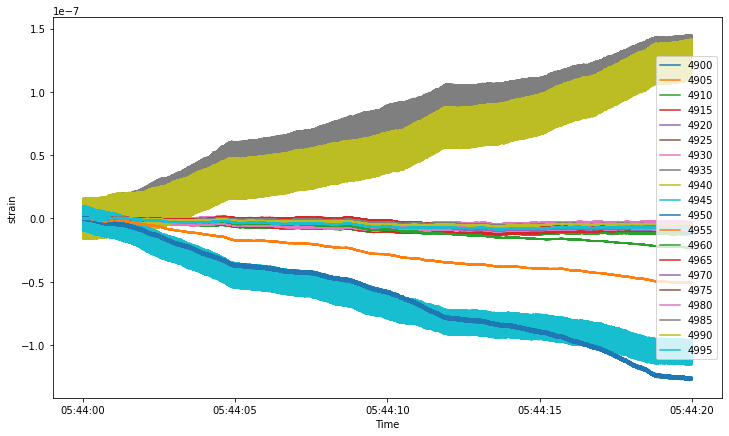

In [85]:
plt.figure(2,clear=True)
for ch in range(4900,5000,5):
    plt.plot(signal[ch], label=str(ch))
plt.legend()
plt.xlabel('Time')
plt.ylabel(signal.meta['unit'])

The `.loc`-method can be used to extract a subset in time and or position:

,4920,4925,4930,4935,...,4960,4965,4970,4975
2021-05-31 05:44:00.000000,-2.885513e-10,-2.389051e-10,4.657998e-10,4.839103e-09,...,-4.127062e-10,-1.900794e-10,-1.722198e-10,-2.089272e-10
2021-05-31 05:44:00.000100,-2.829738e-10,-2.779935e-10,1.263085e-09,7.627590e-09,...,-4.194280e-10,-1.834083e-10,-7.425165e-11,-1.657800e-10
2021-05-31 05:44:00.000200,-2.358637e-10,-2.375184e-10,1.842201e-09,9.652411e-09,...,-4.196022e-10,-2.805395e-10,-1.943672e-10,-9.861718e-11
2021-05-31 05:44:00.000300,-2.959214e-10,-2.565644e-10,2.251984e-09,1.134797e-08,...,-3.664342e-10,-7.034716e-11,3.729861e-11,-1.025050e-10
...,...,...,...,...,...,...,...,...,...
2021-05-31 05:44:02.999700,-6.436246e-11,-3.113362e-11,-1.999723e-09,-6.774649e-09,...,-7.095708e-11,-2.881364e-11,-1.042024e-10,-1.949274e-10
2021-05-31 05:44:02.999800,-1.651812e-10,8.645386e-11,-2.754347e-09,-9.662005e-09,...,1.448101e-11,8.724183e-11,-2.432639e-11,1.615638e-11
2021-05-31 05:44:02.999900,-1.008369e-11,5.339545e-11,-3.118708e-09,-1.061859e-08,...,-6.212298e-11,1.336390e-11,-3.042472e-11,-8.057618e-11
2021-05-31 05:44:03.000000,-4.360601e-11,1.194738e-10,-2.905111e-09,-1.001981e-08,...,3.743516e-11,-5.148029e-11,-1.242674e-10,-3.683475e-11


(18778.23888888889, 18778.238889004628)

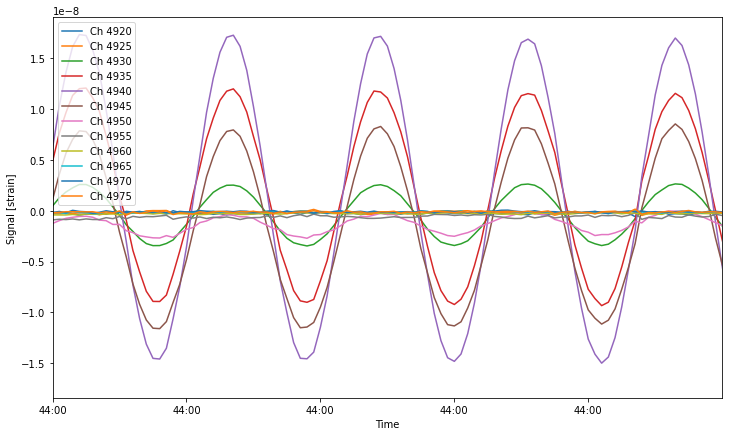

In [150]:
chs = np.arange(4920,4980,5)
signal_subset = signal.loc[:signal.index[0]+datetime.timedelta(seconds=3.),chs] #extract 3 s from start of ch 7500,8000,8500,9000 and 9500

#detrend data inplace
sps.detrend(signal_subset,axis=0,overwrite_data=True) 

#highpass filtering
sos = sps.butter(4,2,'highpass',output='sos',fs=1/signal_subset.meta['dt'])
filtout = sps.sosfilt(sos,signal_subset.values,axis=0)
signal_subset.loc[:,:] = filtout # replaceing data with filter result


display(signal_subset)
fig, ax = plt.subplots(1,1,clear=True,num=3)
ax.plot(signal_subset)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time')
ax.set_ylabel('Signal [%s]' % signal.meta['unit'])

#modifying the format of the time axis
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%M:%S")) #shows only minutes and seconds
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3)) #Allow for less ticks on xaxis, default=5
ax.set_xlim([signal_subset.index[0],signal_subset.index[0]+datetime.timedelta(microseconds=10000)])

Sometimes it may be a bit cumbersome to use the datetime.datetime object as xaxis. However, the index be replaced by an index of floats in unit seconds.

(1.0, 1.01)

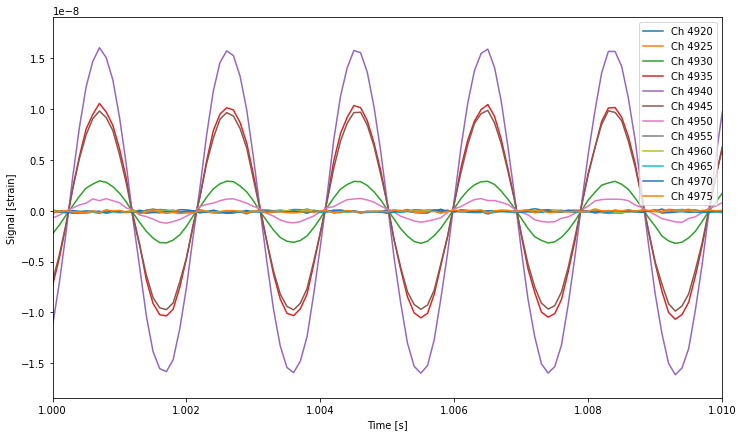

In [119]:
t = (signal_subset.index-signal_subset.index[0]).total_seconds() # seconds from start of data
signal_tzero=signal_subset
signal_tzero['t']=t
signal_tzero.set_index('t',inplace=True) # set t as the new index
fig, ax = plt.subplots(1,1,clear=True,num=3)
ax.plot(signal_tzero)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal [%s]' % signal.meta['unit'])
ax.set_xlim([1.0,1.01])

Another option is to call matplotlib with a separate argument for the time axis:

Text(0, 0.5, 'Signal [strain]')

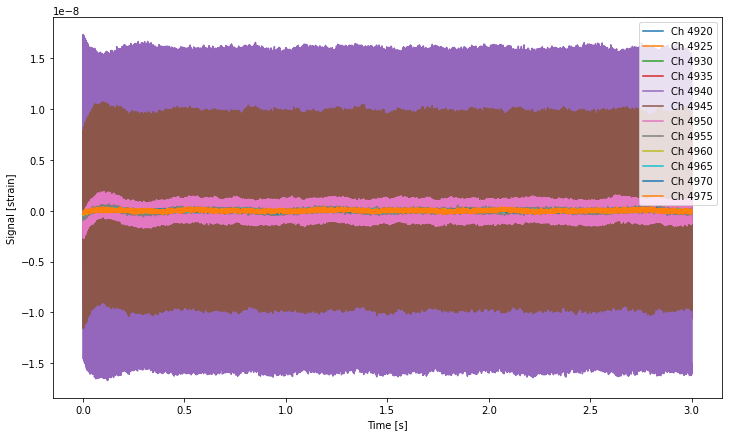

In [120]:
fig, ax = plt.subplots(1,1,clear=True,num=3)
ax.plot(t,signal_subset)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal [%s]' % signal.meta['unit'])

(1.0, 1.01)

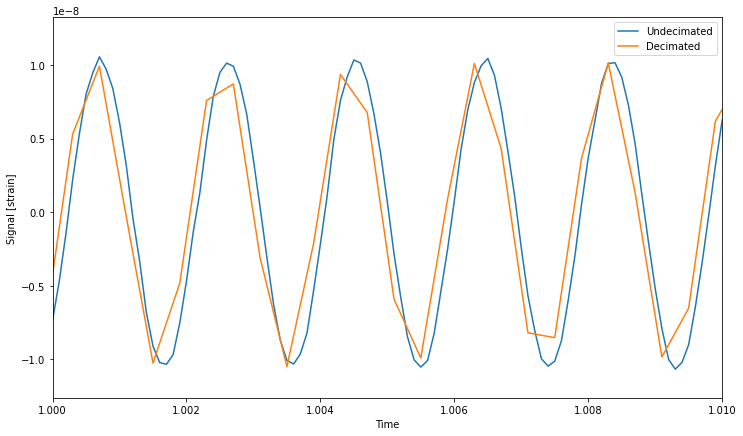

In [155]:
#%% decimate signal

decimation_factor = 4
Nt_in = signal_subset.shape[0]
# Alternative decimation methods. NB! these methods returns ndarray not DataFrame, even for DataFrame input
#sig_decimated = sps.resample(signal,Nt_in//decimation_factor) # resample in frequency domain
#sig_decimated = sps.decimate(signal, decimation_factor,ftype='fir',axis=0) # resample with filter
sig_decimated = sps.resample_poly(signal_subset,up=1,down=decimation_factor,axis=0,padtype='edge') # resample with polyphase filter implementation

Nt_out = sig_decimated.shape[0]
dt_out = signal.meta['dt']*Nt_in/Nt_out
tstart = signal.meta['time'] + datetime.timedelta(seconds=0) # may add a timeoffset to adjust for processing delay
# Time axis with absolute time:
#t = simpleDASreader.create_time_axis(tstart,sig_decimated.shape[0],dt_out)
# or time axis relative time
t = np.arange(Nt_out)*dt_out # seconds from start of data
meta_out= signal.meta.copy()
meta_out.update(dt= dt_out,time=tstart)
signal_decimated = simpleDASreader.DASDataFrame(sig_decimated,index=t,columns=signal_subset.columns,
                                               meta = meta_out)

fig,ax=plt.subplots(1,1,clear=True,num=3)
ax.plot(signal_tzero[4935],label='Undecimated')
ax.plot(signal_decimated[4935],label='Decimated')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Signal [%s]' % signal.meta['unit'])
ax.set_xlim([1.0,1.01])

## Saving data

A DASDataFrame can be saved as a DAS hdf5-file, that can be read by load_DAS_files. Only a subset of the original metadata is saved. The filename is derived from the timestamp:

In [160]:
help(simpleDASreader.save_to_DAS_file)

Help on function save_to_DAS_file in module simpleDASreader8:

save_to_DAS_file(signal, filepath=None, datatype='processed')
    Save a DASDataframe to file in a format that is readable for load_DAS_files.
    Note that just a small subset of the meta information from original files are 
    kept.
    Useful when a preprocessing step is required where the intermediate result
    should be saved.
    
    Parameters
    ----------
    signal : DASDataframe
        The dataframe to be saved
    filepath : str, optional
        The filepath to which the data is saved.
        If None, the data is save to a file derived from the start time 
        signal.meta['time'] and datatype in the path with datatype input parameter.
        E.g. a file read as /raid1/exp/exp1/20200101/dphi/120000.hdf5 will be
        saved as /raid1/exp/exp1/20200101/processed/120000.hdf5 
        The default is None.
    datatype : str, optional
        A sub-directory desnoting the data. The default is 'processed'

In [161]:
filename_out = simpleDASreader.save_to_DAS_file(signal_decimated)

from print_hdf5 import print_file
print_file(filename_out)



Saving to file: /raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/processed/054400.hdf5
Open file: /raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/processed/054400.hdf5
Load dictinary from  within /raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/processed/054400.hdf5:
data (float32):               (7501, 12)
fileVersion (int32):          7
header
	channels (int64):             [4920 4925 4930 4935 4940 4945 4950 4955 4960 4965 4970 4975]
	dataScale (float32):          1.0
	dataType (int32):             3
	dt (float64):                 0.00039996000533262235
	dx (float64):                 1.0213001907746815
	filepaths (|S93):             [b'/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/dphi/054357.hdf5'
 b'/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/20210531/dphi/054407.hdf5'
 b'/raid1/FSI_Projects/Commercial/DASdisplay_demo_files/FrequencySweep/2021